In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from collections import OrderedDict

In [2]:
def createGraph(depotNodes ,requiredEdges, numNodes, show=True):
    G = nx.Graph()
    edges = []
    pos = {}
    reqPos = {}
    s = [1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 6, 7]
    t = [2, 3, 4, 6, 4, 5, 5, 7, 6, 8, 7, 8]
    weights = [2.3, 2, 3, 1.5, 3.2, 2.2, 3.8, 2.6, 2.2, 2.8, 1.8, 0.8]
    xData = [-2, -0.5, -1,   0, 1,  1.5, 2,   2.5];
    yData = [ 0, -2,    2.5, 0, 3, -2,   0.3, 1.5];
    for i in range(len(s)):
        edges.append((s[i], t[i], weights[i]))
    
    for i in range(1, numNodes+1):
        G.add_node(i)
        pos[i] =(xData[i-1], yData[i-1])
    
    node_color = ['y']*int(G.number_of_nodes())
    depot_node_color = node_color
    for i in range(1, len(node_color)+1):
        if i in depotNodes:
            depot_node_color[i-1] = 'g'
            
    G.add_weighted_edges_from(edges)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx(G,pos, node_color = node_color)
    nx.draw_networkx(G,pos, node_color = depot_node_color)
    nx.draw_networkx_edges(G, pos, edgelist=requiredEdges, width=3, alpha=0.5,
                                        edge_color="r")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    if show:
        plt.figure(1)
        plt.show()
    return G,pos, depot_node_color

In [3]:
# Allocating task based on distance between base station and desired edge and UAV availability
def taskAllocation(G, depotNodes, requiredNodes, numrequiredEdges):
    depotNodesCost = np.zeros((len(depotNodes), numrequiredEdges))
    depotPath = []
    bestPathTillDesiredEdge = []
    bestCostTillDesiredEdge = []

    for j in range(numrequiredEdges):
        for i in range(len(depotNodes)):
            c1 = nx.dijkstra_path_length(G, source=depotNodes[i], target=requiredNodes[j][0])
            c2 = nx.dijkstra_path_length(G, source=depotNodes[i], target=requiredNodes[j][1])
            l = []
            if c1 <= c2:
                l = nx.dijkstra_path(G, source=depotNodes[i], target=requiredNodes[j][0])
                l.append(requiredNodes[j][1])
            else:
                l = nx.dijkstra_path(G, source=depotNodes[i], target=requiredNodes[j][1])
                l.append(requiredNodes[j][0])
            depotNodesCost[i,j] = min(c1,c2)
            depotNodesCost[i,j] += G.get_edge_data(requiredNodes[j][0], requiredNodes[j][1])['weight']
            depotPath.append(l)
            
#         if uavsInDepotNodes[np.argmin(depotNodesCost[:,j])] > 0:
#                 uavsInDepotNodes[np.argmin(depotNodesCost[:,j])] -= 1
#         else:
#             depotNodesCost[np.argmin(depotNodesCost[:,j]),j] = np.inf
    depotPath = np.transpose(np.array(depotPath, dtype=object).reshape((numrequiredEdges, len(depotNodes))))
    taskAllocatedtoBaseStations = []
    print("Task Allocation Algorithm Output: ")
    for i in range(numrequiredEdges):
        taskAllocatedtoBaseStations.append(np.argmin(depotNodesCost[:,i]))
        bestCostTillDesiredEdge.append(depotNodesCost[taskAllocatedtoBaseStations[i],i])
        bestPathTillDesiredEdge.append(depotPath[taskAllocatedtoBaseStations[i],i])
        print('Allocating arc ' + str(requiredNodes[i][0]) + ' - ' + str(requiredNodes[i][1]) + ' to base station - node ' + str(depotNodes[taskAllocatedtoBaseStations[i]]))
    
    return bestPathTillDesiredEdge, bestCostTillDesiredEdge

In [4]:
def augment(G, numrequiredEdges,depotNodes, bestPathTillDesiredEdge, bestCostTillDesiredEdge, vehicleCapacity):
    bestRoute = []
    bestRouteCost = []
    minCost = np.inf
    for j in range(numrequiredEdges):
        minCost = np.inf
        l = []
        for i in range(len(depotNodes)):
            c1 = nx.dijkstra_path_length(G, source=bestPathTillDesiredEdge[j][-1], target=depotNodes[i])
            if c1 <= minCost:
                l = nx.dijkstra_path(G, source=bestPathTillDesiredEdge[j][-1], target=depotNodes[i])[1:]
                minCost = c1
        bestRoute.append(bestPathTillDesiredEdge[j] + l)
        bestRouteCost.append(bestCostTillDesiredEdge[j] + minCost)
#         if bestRouteCost[j] > vehicleCapacity:
#             bestRoute[j] = None
#             bestRouteCost[j] = np.inf
    print("Augment Step Output: ")
    return bestRoute, bestRouteCost

In [5]:
def merge(G, bestRoute, depotNodes, bestRouteCost, requiredNodes, numrequiredEdges):
    reverseSortedCost = sorted(bestRouteCost, reverse=True)
    reverseSortedPaths = []
    mergedOrder = []
    reverseSortPaths = {}
    sortedOrder = []

    for i in range(len(bestRouteCost)):
        sortedOrder.append(bestRouteCost.index(reverseSortedCost[i]))
        reverseSortedPaths.append(bestRoute[sortedOrder[i]])

    mergedPath = [0]*math.factorial(numrequiredEdges)
    mergedCost = [0]*math.factorial(numrequiredEdges)
    p = 0
    for i in range(numrequiredEdges-1,-1,-1):
        for j in range(i):
            for k in range(len(reverseSortedPaths[j])):
                if reverseSortedPaths[j][k] == requiredNodes[sortedOrder[j]][0] or reverseSortedPaths[j][k] == requiredNodes[sortedOrder[j]][1]:
                    mergedPath[p] = reverseSortedPaths[j][:k+2]
                    startIndex = reverseSortedPaths[j][k+1]
                    for y in range(len(mergedPath[p])-1):
                        mergedCost[p] += G.get_edge_data(mergedPath[p][y], mergedPath[p][y+1])['weight']
                    break

            c1 = nx.dijkstra_path_length(G, source=startIndex, target=requiredNodes[sortedOrder[i]][0])
            c2 = nx.dijkstra_path_length(G, source=startIndex, target=requiredNodes[sortedOrder[i]][1])
            l = []
            if c1 <= c2:
                if c1 != 0:
                    mergedPath[p] += nx.dijkstra_path(G, source=startIndex, target=requiredNodes[sortedOrder[i]][0])[1:]
                    mergedPath[p].append(requiredNodes[sortedOrder[i]][1])
                    mergedCost[p] += c1
                else:
                    mergedPath[p] += nx.dijkstra_path(G, source=startIndex, target=requiredNodes[sortedOrder[i]][1])[1:]
            else:
                if c2 != 0:
                    mergedPath[p] += nx.dijkstra_path(G, source=startIndex, target=requiredNodes[sortedOrder[i]][1])[1:]
                    mergedPath[p].append(requiredNodes[sortedOrder[i]][0])
                    mergedCost[p] += c2
                else:
                    mergedPath[p] += nx.dijkstra_path(G, source=startIndex, target=requiredNodes[sortedOrder[i]][0])[1:]

            mergedCost[p] += G.get_edge_data(requiredNodes[sortedOrder[i]][0], requiredNodes[sortedOrder[i]][1])['weight']
            minCost = np.inf
            l = []
            for q in range(len(depotNodes)):
                c1 = nx.dijkstra_path_length(G, source=mergedPath[p][-1], target=depotNodes[q])
                if c1 <= minCost:
                    l = nx.dijkstra_path(G, source=mergedPath[p][-1], target=depotNodes[q])[1:]
                    minCost = c1
            mergedPath[p] += l
            mergedCost[p] += minCost
            mergedOrder.append([i, j])
            p += 1
    
    mergedPath = [i for i in mergedPath if i!= 0]
    mergedCost = [i for i in mergedCost if i!= 0]
    print("Merge Step Output: ")
    return mergedPath, mergedCost, mergedOrder, sortedOrder

In [13]:
def finalPathAndCost(mergedPath, mergedCost, mergedOrder, sortedOrder, bestRoute, bestRouteCost, numrequiredEdges):
    allPath = []
    finalPath = []
    finalCost = [0]*len(mergedCost)

    for j in range(len(mergedCost)):
        allPath = []
        allPath.append(mergedPath[j])
        for i in range(numrequiredEdges):
            if i not in mergedOrder[j]:
                allPath.append(bestRoute[sortedOrder[i]])
                finalCost[j] += mergedCost[j] + bestRouteCost[sortedOrder[i]]
        finalPath.append(allPath)
    print("Final Path and Final Costs are")
    print(finalCost)
    return finalPath[finalCost.index(min(finalCost))], finalCost[finalCost.index(min(finalCost))]


In [14]:
def visualizePath(depotNodes, requiredNodes, numNodes, path, pathType="solution"):
    plt.figure(1)
    for j in range(len(path)):
        if path[j] != None:
#             plt.figure(j+1)
            G, pos, depot_node_color = createGraph(depotNodes, requiredNodes , numNodes, show=False)
            G1 = nx.DiGraph()
            pos1 = {}
            node_color = []
            edges = []
            for i in range(len(path[j])-1):
                edges.append((path[j][i], path[j][i+1], G.get_edge_data(path[j][i], path[j][i+1])['weight']))
                pos1[path[j][i]] = pos[path[j][i]]
                if i == len(path[j])-2:
                    pos1[path[j][i+1]] = pos[path[j][i+1]]

            for key in pos1.keys():
                node_color.append(depot_node_color[key-1])

            G1.add_weighted_edges_from(edges)
            nx.draw_networkx(G1,pos1, arrows=True, node_color = node_color, edge_color='b', arrowsize=12, width=1, arrowstyle='simple')
            if pathType == "solution":
                plt.legend(["Solution Path"], loc ="upper left")
            else:
                plt.legend(["Path"], loc ="upper left")
            plt.show()

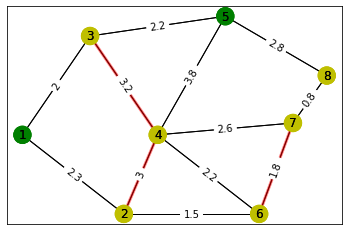

Task Allocation Algorithm Output: 
Allocating arc 2 - 4 to base station - node 1
Allocating arc 6 - 7 to base station - node 5
Allocating arc 3 - 4 to base station - node 1


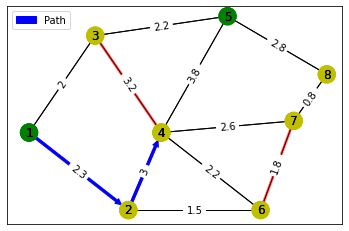

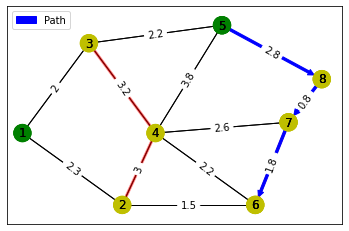

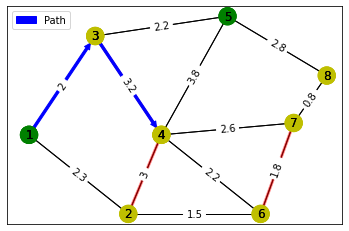

Augment Step Output: 
[9.1, 9.2, 9.0]


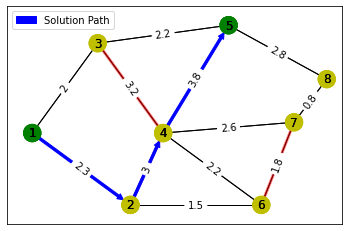

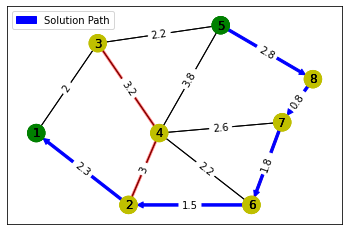

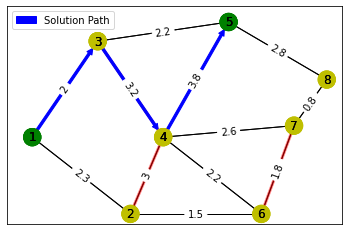

Merge Step Output: 


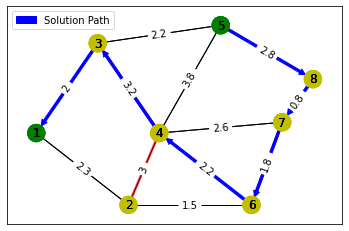

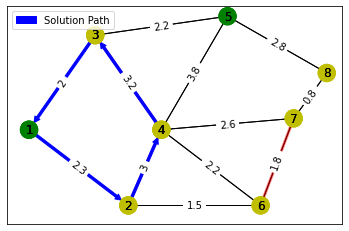

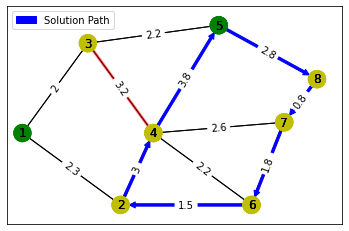

Final Path and Final Costs are
[21.9, 19.7, 22.7]
19.7


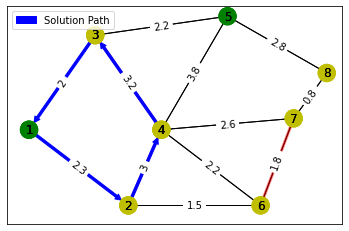

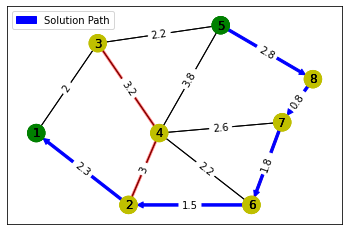

In [15]:
def main():
    vehicleCapacity = 14
    numNodes = 8
    requiredNodes = [[2, 4], [6, 7], [3, 4]];
    uavsInDepotNodes = [0, 2];
    totalUavs = sum(uavsInDepotNodes);
    numrequiredEdges = len(requiredNodes);
    depotNodes = [1, 5];
    G,pos, depot_node_color = createGraph(depotNodes, requiredNodes, numNodes, show=True)
    bestPathTillDesiredEdge, bestCostTillDesiredEdge = taskAllocation(G, depotNodes, requiredNodes, numrequiredEdges)
    visualizePath(depotNodes, requiredNodes, numNodes, bestPathTillDesiredEdge, pathType="normal")
    bestRoute, bestRouteCost = augment(G, numrequiredEdges, depotNodes, bestPathTillDesiredEdge, bestCostTillDesiredEdge, vehicleCapacity)
    print(bestRouteCost)
    visualizePath(depotNodes, requiredNodes, numNodes, bestRoute)
    mergedPath, mergedCost, mergedOrder, sortedOrder = merge(G, bestRoute, depotNodes, bestRouteCost, requiredNodes, numrequiredEdges)
    visualizePath(depotNodes, requiredNodes, numNodes, mergedPath)
    finalPath, finalCost = finalPathAndCost(mergedPath, mergedCost, mergedOrder, sortedOrder, bestRoute, bestRouteCost, numrequiredEdges)
    print(finalCost)
    visualizePath(depotNodes, requiredNodes, numNodes, finalPath)

if __name__ == "__main__":
    # execute only if run as a script
    main()